# Projet Fixmatch

In [4]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [1]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

# os
import os
import path

import random
import numpy as np 

# transformations
# import transform as T
# from randaugment import RandomAugment

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autoreload
%autoreload 2

In [2]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [4]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95 #! 0.95 in the paper
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005
BETA_DENSITY = 1

In [5]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self, return_features=False):
        super().__init__()
        self.return_features = return_features
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)

        if self.return_features:
            return x

        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)
        # x = self.softmax(x)

        return x


In [6]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean += torch.mean(images, dim=[0,2,3])
        std += torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.49135667 0.48212072 0.4465159 ], std: [0.24632095 0.24274482 0.26062676]
Files already downloaded and verified


In [7]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

In [8]:
model_full = ConvNN(return_features=True).to(device)
model_full.load_state_dict(torch.load(f'{torch_models}/model_10_fixmatch_DA.pth'))

<All keys matched successfully>

In [9]:
# import torch
# import torch.nn as nn

# class ClusteringLayer(nn.Module):
#     """
#     La couche de classification convertit l'échantillon d'entrée (caractéristique) en une étiquette souple, c'est-à-dire un vecteur qui représente la probabilité d'appartenance de l'échantillon à chaque cluster.
#     La probabilité d'appartenance de l'échantillon à chaque cluster est calculée avec la distribution t de Student.

#     # Exemple
#     ```
#     model.add(ClusteringLayer(n_clusters=10))
#     ```

#     # Arguments
#     n_clusters : int - Nombre de clusters.
#     weights : list of PyTorch tensors of shape `(n_clusters, n_features)` - Représente les centres de clusters initiaux.
#     alpha : float - Paramètre de la distribution t de Student. La valeur par défaut est 1.0.

#     # Forme de l'entrée
#     Tenseur 2D avec la forme : `(n_samples, n_features)`.

#     # Forme en sortie
#     Tenseur 2D avec la forme : `(n_samples, n_clusters)`.
#     """
#     def __init__(self, n_clusters, weights=None, alpha=1.0):
#         super(ClusteringLayer, self).__init__()
#         self.n_clusters = n_clusters
#         self.alpha = alpha

#         if weights is not None:
#             self.weights = nn.Parameter(torch.tensor(weights))
#         else:
#             self.weights = nn.Parameter(torch.Tensor(n_clusters))

#         if self.initial_weights is not None:
#             assert self.initial_weights.shape == self.clusters.shape
#             self.clusters.data.copy_(torch.from_numpy(self.initial_weights))

#     def forward(self, x):
#         q = 1.0 / (1.0 + (torch.sum((x.unsqueeze(1) - self.weights) ** 2, dim=2) / self.alpha))
#         q = q ** ((self.alpha + 1.0) / 2.0)
#         q = (q.t() / torch.sum(q, dim=1)).t()
#         return q

In [10]:
# # from sklearn.cluster import KMeans
# # Define a simple CNN model
# class ConvNN_DC(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         model_full = ConvNN(return_features=True).to(device)
#         model_full.load_state_dict(torch.load(f'{torch_models}/model_100.pth'))

#         self.features = model_full
#         self.clustering_layer = ClusteringLayer(n_clusters=10)
    
#     def forward(self, x):
#         x = self.features(x)
#         x = self.clustering_layer(x)
#         return x

In [11]:
# model_test = ConvNN().to(device)
# model_test.load_state_dict(torch.load(f'{torch_models}/model_100.pth'))

# # test model_full
# model_full.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in testloader:
#         images = normalize(data=images, mean=mean, std=std)

#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model_test(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}')


In [12]:
# model_test = ConvNN_DC(return_there=True).to(device)
# # model_test.load_state_dict(torch.load(f'{torch_models}/model_100.pth'))

# # test model_full
# model_full.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in testloader:
#         images = normalize(data=images, mean=mean, std=std)

#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model_test(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}')


In [13]:
# # Calcul de la distribution cible
# def target_distribution(q):
#     # à compléter
#     weight = q ** 2 / q.sum(0)
#     return (weight.T / weight.sum(1)).T

# def retrieve_info(
#     cluster_labels: np.ndarray,
#     y_train: np.ndarray) -> np.ndarray:

#     # Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
#     # Résultats : dictionnaire des clusters associés à chaque étiquette.

#     # Initialisation
#     reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
#     # Loop pour chaque label 
#     for i in range(len(np.unique(cluster_labels))):
#         index = np.where(cluster_labels == i, 1, 0)
#         num = np.bincount(y_train[index==1]).argmax()
#         reference_labels[i] = num

#     return reference_labels

# def correspondance(y_pred_kmeans, y_train):
#     # Correspondance entre la partition et les classes de la vérité terrain
#     reference_labels = retrieve_info(y_pred_kmeans, y_train)
#     number_labels = np.zeros(len(y_pred_kmeans))
#     for i in range(len(y_pred_kmeans)):
#         number_labels[i] = reference_labels[y_pred_kmeans[i]]
#     return np.array(number_labels, dtype=int)

## IV. Semi-Supervised Learning: Fixmatch with KMeans Clustering on feature space

### IV.1 Fixmatch on 10% train data with KMeans Clustering 

In [14]:
from sklearn.cluster import KMeans

In [15]:
# seedEverything()

# model_DC = ConvNN_DC().to(device)
# optimizer_DC = torch.optim.Adam(model_DC.parameters(), lr=LR)
# criterion_DC = nn.KLDivLoss(reduction='batchmean')

In [26]:
type(trainset)

torchvision.datasets.cifar.CIFAR10

In [30]:
len(trainset)

50000

In [38]:
# cluster centers
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto')
outputs_list = []

# train KMeans on batch
pbar = tqdm(trainset, total=len(trainset))
for i, (train_data) in enumerate(pbar):
    images, labels = train_data

    images = normalize(data=images.unsqueeze(0), mean=mean, std=std)
    images = images.to(device)

    # Forward pass
    outputs = model_full(images).detach().cpu().numpy()
    outputs_list.append(outputs)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [45]:
# stack outputs
outputs_list_array = np.vstack(outputs_list)

# fit KMeans
kmeans.fit(
    outputs_list_array
)

KMeans(n_clusters=10, n_init='auto', random_state=0)

In [46]:
y_pred_list = []

# predict
pbar = tqdm(trainset, total=len(trainset))
for i, (train_data) in enumerate(pbar):
    images, labels = train_data

    images = normalize(data=images.unsqueeze(0), mean=mean, std=std)
    images = images.to(device)

    # Forward pass
    outputs = model_full(images).detach().cpu().numpy()

    # predict
    y_pred = kmeans.predict(outputs)

    y_pred_list.append(y_pred)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [48]:
# stack predictions
y_pred_list_array = np.hstack(y_pred_list)

In [49]:
# compute distance between each data point and cluster centers
distances = kmeans.transform(outputs_list_array)

In [69]:
# filter distance to closest cluster center according to prediction
distances_filtered = np.array(
    [distances[i, y_pred_list_array[i]] for i in range(len(y_pred_list_array))]
)

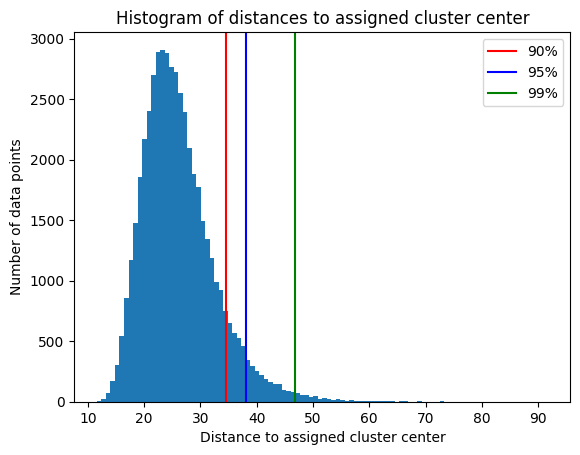

In [84]:
# show histogram and horizontal line where X% of the data is
plt.hist(distances_filtered, bins=100)
plt.axvline(np.percentile(distances_filtered, 90), color='red', label='90%')
plt.axvline(np.percentile(distances_filtered, 95), color='blue', label='95%')
plt.axvline(np.percentile(distances_filtered, 99), color='green', label='99%')
plt.xlabel('Distance to assigned cluster center')
plt.ylabel('Number of data points')
plt.title('Histogram of distances to assigned cluster center')
plt.legend()
plt.show()

In [98]:
distances.shape

(50000, 10)

In [121]:
# get data point closest to cluster centers
distances_argmin = np.argmin(distances, axis=0)
distances_argmin

array([ 1432, 43413, 43686, 45505, 11380, 11539, 37858,  2922,   420,
       11547])

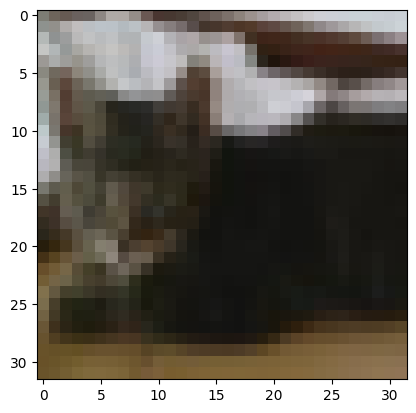

In [129]:
# plot image
plt.imshow(
    np.transpose(
        trainset[9][0].numpy(),
        (1, 2, 0)
    )
)


In [120]:
distances[:, 3]

array([37.039413, 35.696106, 36.407997, ..., 32.624767, 45.405422,
       33.0042  ], dtype=float32)

In [125]:
# for each class, compute the data point closest to the cluster center
distances_argmin = []
for i in range(10):
    distances_argmin.append(np.argmin(distances[:, i], axis=0))

In [126]:
distances_argmin

[1432, 43413, 43686, 45505, 11380, 11539, 37858, 2922, 420, 11547]

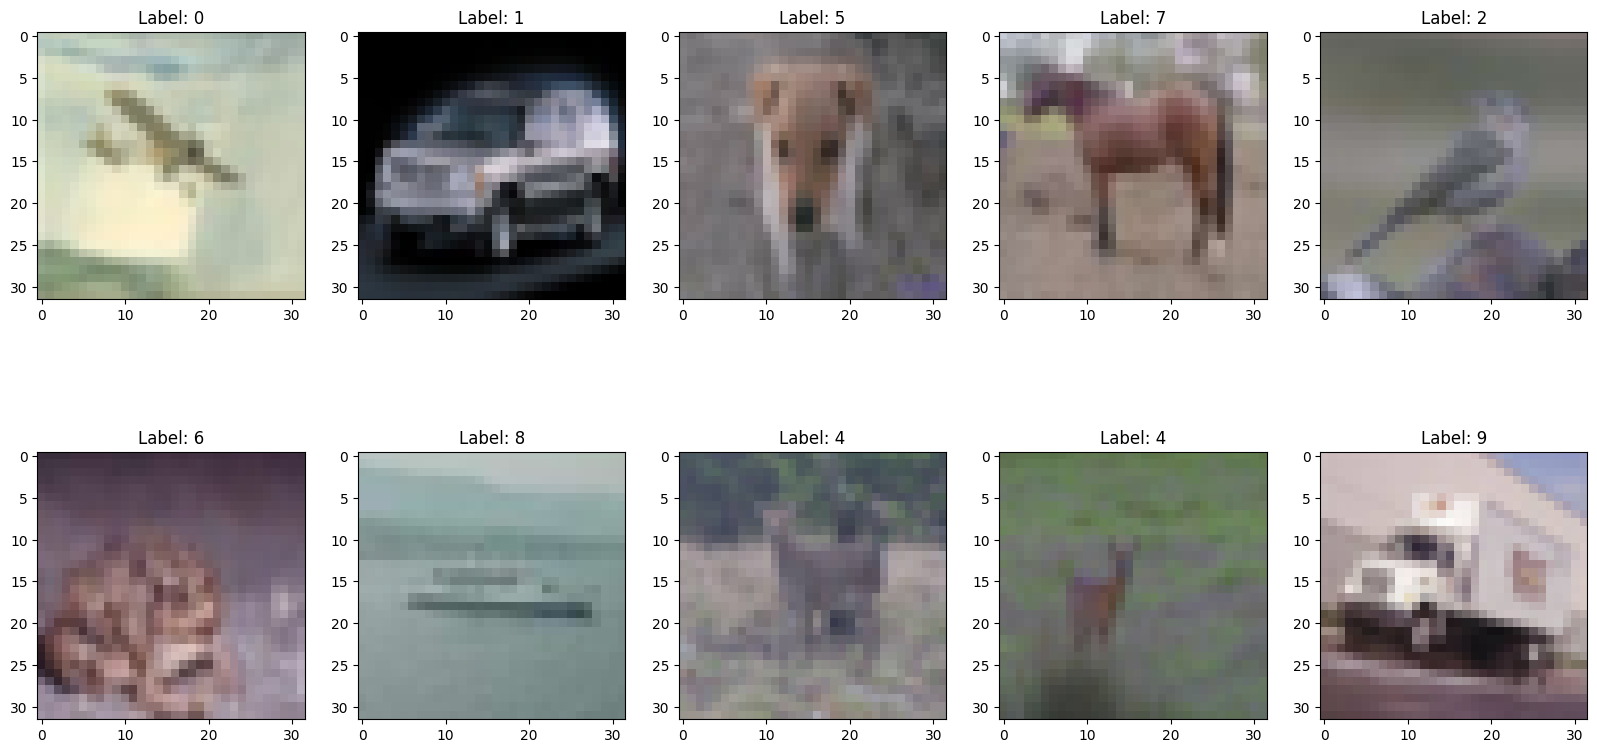

In [117]:
# plot images closest to cluster centers
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    ax[i//5, i%5].imshow(trainset[distances_argmin[i]][0].squeeze().numpy().transpose(1,2,0))
    ax[i//5, i%5].set_title(f'Label: {trainset[distances_argmin[i]][1]}')
plt.show()

In [20]:
# cluster of each sample
pbar = tqdm(trainloader, total=len(trainloader), unit="batch")
for i, (train_data) in enumerate(pbar):
    images, labels = train_data

    images = normalize(data=images, mean=mean, std=std)
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model_full(images).detach().cpu().numpy()

    # predict cluster
    y_pred_kmeans = kmeans.predict(outputs)

In [23]:
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [21]:
y_pred_kmeans

array([0, 0, 5, 9, 2, 3, 8, 0, 7, 4, 0, 6, 0, 0, 1, 2], dtype=int32)

In [67]:
# train deep clustering model using model full as feature extractor
num_epochs = 10

model_full.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        # extract features using model full
        features = model_full(images)
        feature_dim = np.prod(features.size()[1:])
        features_2d = features.view(BATCH_SIZE, feature_dim)


        # perform clustering
        kmeans = KMeans(n_clusters=20, random_state=0, n_init='auto')
        cluster_labels = kmeans.fit_predict(features_2d.detach().cpu().numpy())

        # convert cluster labels to one-hot encoding
        target = torch.zeros((images.shape[0], 20))
        target[range(target.shape[0]), cluster_labels] = 1

        # compute loss
        loss = loss_DC(features_2d, target.to(device))

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1} / {num_epochs}, Loss: {epoch_loss:.4f}')

torch.Size([64, 3, 32, 32])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 20])) that is different to the input size (torch.Size([64, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (512) must match the size of tensor b (20) at non-singleton dimension 1

In [70]:
cluster_labels

array([ 5,  5,  5,  2,  5,  5,  5,  5,  8,  5,  7,  5,  5,  5,  5,  4,  5,
        5,  4,  4,  9,  0, 16,  4, 13,  4,  5, 12,  4, 19, 15,  4,  5,  3,
        4,  5,  4,  7,  4,  5,  5, 17,  9,  5,  0, 18,  6,  4,  5,  4,  4,
        0,  4,  5,  9,  5,  4,  1, 11,  9, 10, 14,  5,  7], dtype=int32)

In [69]:
features_2d.shape

torch.Size([64, 512])

In [178]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.01
K_SAMPLES = 1

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# indices of labeled data
labeled_indices = trainset_sup.indices

# indices of unlabeled data
unlabeled_indices = trainset_unsup.indices

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [179]:
# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10),
)

In [180]:
def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

In [181]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)

In [182]:
def similarity(data: torch.tensor) -> torch.tensor:
    data_norm = normalize(data=data, mean=mean, std=std)

    input1 = data_norm.view(data_norm.shape[0], -1)

    cos_sim = torch.tensor(cosine_similarity(input1.cpu().numpy()), dtype=torch.float32).to(device).flatten()
    # information_density = (torch.sum(torch.tensor(cos_sim), dim=1) / data_norm.shape[0]) ** BETA_DENSITY

    # top k samples
    inf_dens, idx = torch.topk(cos_sim, k=1, largest=True, sorted=True)

    return inf_dens, idx.cpu().numpy()

In [184]:
def information_density(
    model: ConvNN, 
    unlabeled_inputs: torch.Tensor,
    k_samp: int) -> Tuple[torch.Tensor, torch.Tensor]:

    inputs_norm = normalize(data=unlabeled_inputs, mean=mean, std=std)

    logits = model(inputs_norm)
    qb = torch.softmax(logits, dim=1)
    qb1 = torch.topk(qb, k=2, dim=1)[0][:, 0]
    qb2 = torch.topk(qb, k=2, dim=1)[0][:, 1]

    uncertainty = 1 - (qb1 - qb2)

    input1 = inputs_norm.view(inputs_norm.shape[0], -1)

    cos_sim = cosine_similarity(input1.cpu().numpy())
    information_density = (torch.sum(torch.tensor(cos_sim), dim=1) / inputs_norm.shape[0]) ** BETA_DENSITY

    output = uncertainty * information_density.to(device)

    inf_dens, idx = torch.topk(output, k=k_samp, dim=0)
    
    return inf_dens, idx.cpu().numpy()

# Create a new labeled dataset using active learning
def create_labeled_dataset_active_learning(dataset, selected_indices):
    labeled_dataset = torch.utils.data.Subset(dataset, selected_indices)
    return labeled_dataset

In [185]:
print("Start training")

current_prop = SUBSET_PROP
target_prop = 0.05
max_iter = 300
j = 0

# Define the cosine learning rate decay function
# lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * max_iter//3))) * 100 / 3

# cosine annealing scheduler
# lr_lambda = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iter, eta_min=0, last_epoch=-1)

# Create a learning rate scheduler with the cosine decay function
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iter, eta_min=0, last_epoch=-1)


train_losses = []
test_losses = []
added_samp = 0

while j <= max_iter and current_prop <= target_prop:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    # max_confidence = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {j: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, unlabeled_labels = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        

        # Zero the parameter gradients
        optimizer.zero_grad()

        # normalize labeled and unlabeled inputs
        labeled_inputs_norm = normalize(data=labeled_inputs, mean=mean, std=std)
        unlabeled_inputs_norm = normalize(data=unlabeled_inputs, mean=mean, std=std)

        # Forward pass 
        labeled_outputs_norm = model(labeled_inputs_norm)
        unlabeled_outputs_norm = model(unlabeled_inputs_norm)

        # Compute moving average of labeled and unlabeled predictions
        moving_avg_pred_labeled = (i * moving_avg_pred_labeled + labeled_outputs_norm.shape[0]) / (i + 1)
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = moving_avg_pred_labeled / moving_avg_pred_unlabeled

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        
        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled 

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "current_prop": current_prop,
            "lr": optimizer.param_groups[0]['lr']
        })

    if j < max_iter and j%5 == 0 and current_prop < target_prop:
        # compute information density
        scores_density, idx_density = information_density(model, unlabeled_inputs, K_SAMPLES)

        # add selected indices to labeled indices
        labeled_indices = np.concatenate((labeled_indices, idx_density))

        # unique
        labeled_indices = np.unique(labeled_indices)

        # create new dataset from labeled indices
        trainset_sup = create_labeled_dataset_active_learning(trainset, labeled_indices)

        # update dataloader
        labeled_dataloader = torch.utils.data.DataLoader(trainset_sup, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

        current_prop = len(trainset_sup) / len(trainset)

        print(f'Information density: {scores_density.mean()}')
        print(f'Density indices: {idx_density}')

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)

    # increment iteration
    j += 1

Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Information density: 0.10706252604722977
Density indices: [171]
Test Accuracy: 10.0%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
idx_density

array([114,  49,  26,   9, 237,  70, 171, 127, 200, 236, 172,  89,  16,
        37, 208, 243, 140, 119,  73,   8, 166, 203,  64, 207, 196, 108,
       116,   0, 222,  38,  91,  74, 111,   4, 255, 205, 126,  18,  84,
       194, 135, 132, 195,  63, 163,  62, 129, 157,  96,  68,  33,  79,
       216, 248,  13, 101,  54, 238,  46, 245, 113, 229,  25, 155])

In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch_AL.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Active Learning")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch_AL.png")

### III.2 Fixmatch on 5% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.05

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")

### III.3 Fixmatch on 1% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.01

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")